In [181]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, f1_score
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

def binarize_election_res(val):
    if val == "W":
        return 1
    else:
        return 0

def clean_party(party):
    if party == "DEM" or party == "REP":
        return party
    else:
        return "OTHER/INDIE"

df = pd.read_csv("train_set.csv")
df.CAND_PTY_AFFILIATION = df.CAND_PTY_AFFILIATION.apply(clean_party)

del df["Unnamed: 0"]
del df["SPEC_ELECTION"]
del df["RUN_ELECTION"]

log_cols = [
    "TTL_RECEIPTS",
    "TTL_DISB",
    "COH_BOP",
    "COH_COP",
    "CAND_CONTRIB",
    "CAND_LOANS",
    "OTHER_LOANS",
    "CAND_LOAN_REPAY",
    "DEBTS_OWED_BY",
    "TTL_INDIV_CONTRIB",
    "INDIV_REFUNDS",
    "CMTE_REFUNDS",
    "OTHER_POL_CMTE_CONTRIB",
    "POL_PTY_CONTRIB",
    "INDIV_REFUNDS",
    "CMTE_REFUNDS"
]


categoricals = [
    # "CAND_PTY_AFFILIATION",
    "CAND_OFFICE_ST",
    # "PRIM_ELECTION",
]

for col in log_cols:
    df[col] = df[col].apply(np.log1p)

    
df.CVG_END_DT = pd.to_datetime(df.CVG_END_DT)
df["ELECTION_YEAR"] = df.CVG_END_DT.apply(lambda x: x.year)

df["PRIM_ELECTION"] = df.PRIM_ELECTION.apply(binarize_election_res)

del df["CVG_END_DT"]


df = df[df["CAND_PTY_AFFILIATION"].isin(["REP","DEM"])]

In [182]:
df.sample(1).T

,3024
CAND_ID,H2FL01100
CAND_NAME,"MILLER, JEFFERSON B."
CAND_ICI,I
PTY_CD,2
CAND_PTY_AFFILIATION,REP
TTL_RECEIPTS,12.7045
TRANS_FROM_AUTH,0
TTL_DISB,12.6846
TRANS_TO_AUTH,0
COH_BOP,11.507


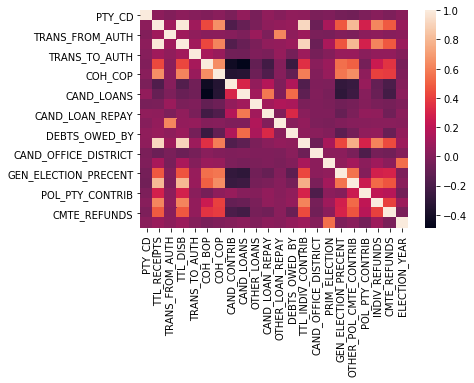

In [183]:
sns.heatmap(df.corr())

In [184]:
numericals = [
                 'PTY_CD',
                 'TTL_RECEIPTS',
                 'TRANS_FROM_AUTH',
                 'TTL_DISB',
                 'TRANS_TO_AUTH',
                 'COH_BOP',
                 'COH_COP',
                 'CAND_CONTRIB',
                 'CAND_LOANS',
                 'OTHER_LOANS',
                 'CAND_LOAN_REPAY',
                 'OTHER_LOAN_REPAY',
                 'DEBTS_OWED_BY',
                 'TTL_INDIV_CONTRIB',
                 'CAND_OFFICE_DISTRICT',
                 'PRIM_ELECTION',
                 'GEN_ELECTION_PRECENT',
                 'OTHER_POL_CMTE_CONTRIB',
                 'POL_PTY_CONTRIB',
                 'INDIV_REFUNDS',
                 'CMTE_REFUNDS',
                 'ELECTION_YEAR'
]

In [185]:
dummies = pd.get_dummies(df[categoricals])
target = df.GEN_ELECTION.apply(binarize_election_res)

train_set = pd.concat([df[numericals], dummies, target],axis=1).dropna()
del train_set["GEN_ELECTION_PRECENT"]

X = train_set[[i for i in train_set if (i != "GEN_ELECTION")]]
y = train_set["GEN_ELECTION"]

In [186]:
train_set.dropna().shape

(4078, 79)

In [187]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [188]:
model = LogisticRegression()
model.fit(X_train, y_train)

print(model.score(X_test, y_test))

0.8725490196078431


/home/david/miniconda3/envs/threeseven/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [240]:
print(f"Accuracy: {accuracy_score(y_test, model.predict(X_test))}")
print(f"F1: {f1_score(y_test, model.predict(X_test))}")

Accuracy: 0.8725490196078431
F1: 0.8867595818815331


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 <a list of 30 Text xticklabel objects>)

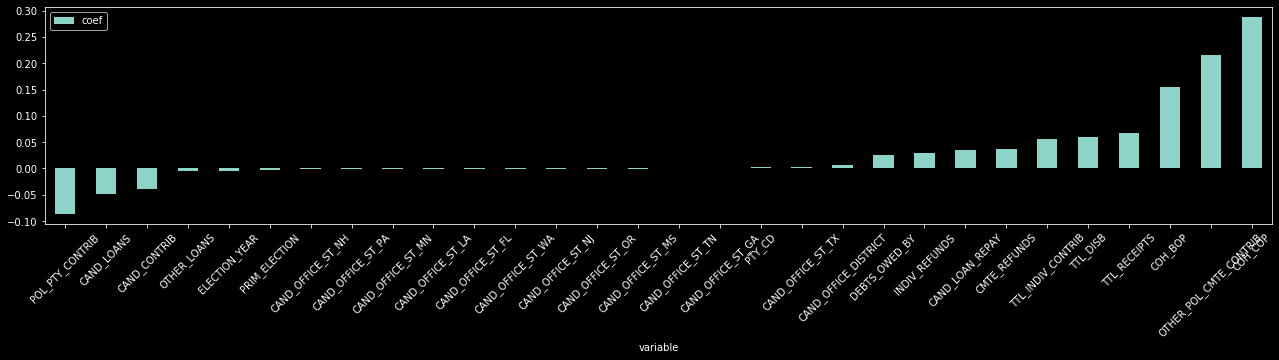

In [201]:
plt.style.use("dark_background")
coefs = pd.DataFrame( {"variable":X_train.columns, "coef": model.coef_[0]} )
pd.concat( [coefs.sort_values("coef").head(15), coefs.sort_values("coef").tail(15)] ).set_index("variable").plot(kind="bar", figsize=(22,4))
plt.xticks(rotation=45)

In [233]:
samples = X_test.sample(5)
preds = ["W" if i == 1 else "L" for i in model.predict(samples) ]

In [239]:
for i,j in enumerate(samples.index):
    print(f"Row ID: {j}")
    print("Candidate: " + df.iloc[j]["CAND_NAME"])
    print(f"Prediction: {preds[i]}")
    print(f"True Value:{df.iloc[j].GEN_ELECTION}")

Row ID: 4063
Candidate: GONZALEZ, CHARLES A.
Prediction: W
True Value:W
Row ID: 517
Candidate: TAUB, ASHER E
Prediction: L
True Value:L
Row ID: 1939
Candidate: QUIGLEY, MIKE
Prediction: W
True Value:W
Row ID: 3184
Candidate: MCLEOD, GARY MILLER
Prediction: W
True Value:L
Row ID: 621
Candidate: PIPE, MICHAEL
Prediction: L
True Value:L
